第七章 集合学习和随机森林

一、Voting classifiers(使用不同算法在单个训练集上进行训练获得不同的分类器或你拟合器)

1、hard voting(数值平均)

2、soft voting(加权平均,更加精确，但训练时间更长)

二、Bagging and pasting(使用同一种算法在多个训练子集上进行训练获得不同的预测器，可并行训练，适用于大型数据集)

（一）、常见算法

1、bagging(允许训练数据点被同一个预测器采样多次)——更好的模型

2、pasting

（二）、Random Patches and Random Subspaces（采样方法）

1、Random Patches(集采样数据又采样特征)

2、Random Subspaces(保留所有数据点，只采样特征)


（三）、随机森林（由决策树构成的集合，通常采用bagging算法进行训练）

三、Boosting（序列优化，无法平行训练，不适用大型数据集）

1、AdaBoost（序列优化，通过调整实例权重训练新的估计器）

2、Gradient Boosting（序列优化,通过拟合上一个估计器遗留下来的残差训练新的估计器）

（1）优化模型树的数量

（2）设置迭代次数的阈值，减少集合中决策树的数量

（3）最常使用的损失函数：均方差（可通过超参数loss调整损失函数）

（4）还可以通过超参数subsample调整决策树采样训练集数据点的比例(高偏差换低方

差，且可以大幅提升训练速度)

四、Stacking（堆叠式算法）



In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import os
os.environ["OMP_NUM_THREADS"]="7"
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from matplotlib.font_manager import FontProperties

# 设置中文宋体和英文Times New Roman字体
chinese_font = FontProperties(fname='path/to/SimSun.ttf')  # 替换为你的宋体字体文件路径
english_font = FontProperties('Times New Roman')

In [5]:
#生成训练集和测试集
X,y=datasets.make_moons()
X_train,X_test=train_test_split(X,test_size=0.2,random_state=42)
y_train,y_test=train_test_split(y,test_size=0.2,random_state=42)

In [3]:
#训练模型（数值平均）
log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()
voting_clf=VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='hard')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
#对各个分类模型进行评分


for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


In [5]:
#训练模型（加权平均）
log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC(probability=True)
voting_clf=VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='soft')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [6]:
#对各个分类模型进行评分


for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


In [7]:
#bagging and pasting
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
tree_clf=DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred_tree=tree_clf.predict(X_test)
print(tree_clf.__class__.__name__,accuracy_score(y_test,y_pred_tree))
for i in [10,20,30,40,50,60,70]:
    bag_clf=BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=i,bootstrap=True,n_jobs=-1)
    bag_clf.fit(X_train,y_train)
    y_pred=bag_clf.predict(X_test)
    print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))


DecisionTreeClassifier 0.85
BaggingClassifier 0.9
BaggingClassifier 0.95
BaggingClassifier 0.95
BaggingClassifier 0.95
BaggingClassifier 0.95
BaggingClassifier 0.9
BaggingClassifier 0.9


In [8]:
#自动在每个预测器未采样到的数据集上进行测试评分
bag_clf=BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,oob_score=True,bootstrap=True,n_jobs=-1)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(bag_clf.oob_decision_function_)


0.925
0.9
[[1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.92       0.08      ]
 [0.         1.        ]
 [1.         0.        ]
 [0.28571429 0.71428571]
 [1.         0.        ]
 [0.8908046  0.1091954 ]
 [1.         0.        ]
 [1.         0.        ]
 [0.20338983 0.79661017]
 [0.00645161 0.99354839]
 [0.9010989  0.0989011 ]
 [1.         0.        ]
 [0.95108696 0.04891304]
 [0.78443114 0.21556886]
 [0.         1.        ]
 [0.07602339 0.92397661]
 [0.         1.        ]
 [0.         1.        ]
 [0.95918367 0.04081633]
 [0.17112299 0.82887701]
 [0.80555556 0.19444444]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.94797688 0.05202312]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.05789474 0.94210526]
 [0.         1.        ]
 [0.         1.        ]
 [0.99453552 0.00546448]
 [0.4244186  0.5755814 ]
 [0.14835165 0.85164835]
 [0.06701031 0.

In [9]:
#直接调用随机森林模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
rnd_clf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)
y_pred_forest=rnd_clf.predict(X_test)
etr_clf=ExtraTreesClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
etr_clf.fit(X_train,y_train)
y_pred_forest=etr_clf.predict(X_test)
#等价模型
bag_clf = BaggingClassifier(
 DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
 n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
rnd_clf.fit(X_train,y_train)
y_pred=rnd_clf.predict(X_test)
print(rnd_clf.__class__.__name__,accuracy_score(y_test,y_pred))
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))
print(etr_clf.__class__.__name__,accuracy_score(y_test,y_pred))



RandomForestClassifier 1.0
BaggingClassifier 1.0
ExtraTreesClassifier 1.0


In [10]:
#可以获取随机森林模型中每个特征对于分类的重要性
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)


sepal length (cm) 0.10007568067359209
sepal width (cm) 0.023536018416687406
petal length (cm) 0.4351813447675302
petal width (cm) 0.4412069561421904


In [12]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [14]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(mnist["data"],mnist["target"])
for name,score in zip(mnist["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

pixel1 0.0
pixel2 0.0
pixel3 0.0
pixel4 0.0
pixel5 0.0
pixel6 0.0
pixel7 0.0
pixel8 0.0
pixel9 0.0
pixel10 0.0
pixel11 0.0
pixel12 0.0
pixel13 6.320661114452465e-08
pixel14 6.339118889287606e-08
pixel15 0.0
pixel16 1.222031130751684e-07
pixel17 0.0
pixel18 0.0
pixel19 0.0
pixel20 0.0
pixel21 0.0
pixel22 0.0
pixel23 0.0
pixel24 0.0
pixel25 0.0
pixel26 0.0
pixel27 0.0
pixel28 0.0
pixel29 0.0
pixel30 0.0
pixel31 0.0
pixel32 0.0
pixel33 0.0
pixel34 2.3601795605139125e-07
pixel35 4.7024247231777677e-07
pixel36 1.7553094556523276e-06
pixel37 1.7900923184686158e-06
pixel38 2.5825016243835926e-06
pixel39 1.781243985635802e-06
pixel40 2.671373070420507e-06
pixel41 3.746136997505442e-06
pixel42 4.4096636720460005e-06
pixel43 4.219889400129546e-06
pixel44 4.043530868751355e-06
pixel45 3.3790708548481963e-06
pixel46 2.7011815869158315e-06
pixel47 9.034977327389594e-07
pixel48 1.0759364502296931e-06
pixel49 9.173699431536768e-07
pixel50 4.2939556095589014e-07
pixel51 7.711036618523232e-07
pixel52 6

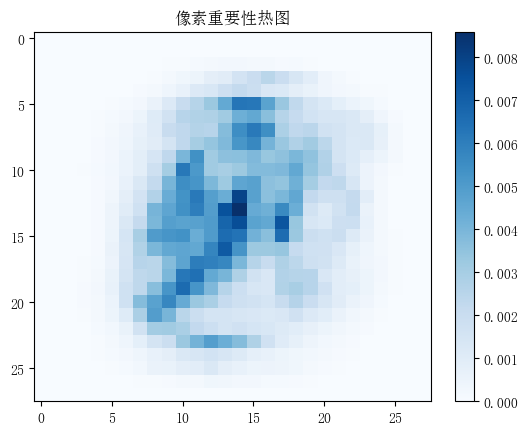

In [28]:
data=rnd_clf.feature_importances_.reshape(28,28)
plt.imshow(data, aspect='auto', cmap='Blues')  # aspect='auto'保持原始的纵横比
plt.colorbar()  # 显示颜色条
plt.title("像素重要性热图")  # 设置标题
plt.show()

In [6]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,algorithm="SAMME.R",learning_rate=0.5)
ada_clf.fit(X_train,y_train)

c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

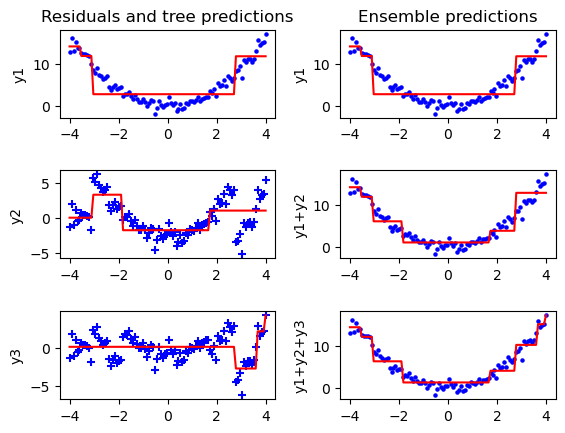

In [55]:
#Gradient Boosting
X=np.linspace(-4,4,100)
Y=X**2+np.random.normal(0,1,100)
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)

from sklearn.tree import DecisionTreeRegressor
tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,Y)

y2=Y-tree_reg1.predict(X).reshape(-1,1)
tree_reg2=DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

y3=y2-tree_reg2.predict(X).reshape(-1,1)
tree_reg3=DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

y_pred=sum(tree.predict(X) for tree in (tree_reg1,tree_reg2,tree_reg3))

#可视化结果
fig,axs=plt.subplots(3,2)
plt.subplots_adjust(wspace=0.3, hspace=0.6)
axs[0,0].scatter(X,Y,c='#0000FF',s=5)
axs[0,0].plot(X,tree_reg1.predict(X),c="r")
axs[0,0].set_title("Residuals and tree predictions")
axs[0,0].set_ylabel("y1")

axs[0,1].scatter(X,Y,c='#0000FF',s=5)
axs[0,1].plot(X,tree_reg1.predict(X),c="r")
axs[0,1].set_title("Ensemble predictions")
axs[0,1].set_ylabel("y1")

axs[1,0].scatter(X,y2,c='#0000FF',marker="+")
axs[1,0].plot(X,tree_reg2.predict(X),c="r")
axs[1,0].set_ylabel("y2")

axs[1,1].scatter(X,Y,c='#0000FF',s=5)
axs[1,1].plot(X,tree_reg1.predict(X)+tree_reg2.predict(X),c="r")
axs[1,1].set_ylabel("y1+y2")

axs[2,0].scatter(X,y3,c='#0000FF',marker="+")
axs[2,0].plot(X,tree_reg3.predict(X),c="r")
axs[2,0].set_ylabel("y3")

axs[2,1].scatter(X,Y,c='#0000FF',s=5)
axs[2,1].plot(X,tree_reg1.predict(X)+tree_reg2.predict(X)+tree_reg3.predict(X),c="r")
axs[2,1].set_ylabel("y1+y2+y3")
plt.show()

c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


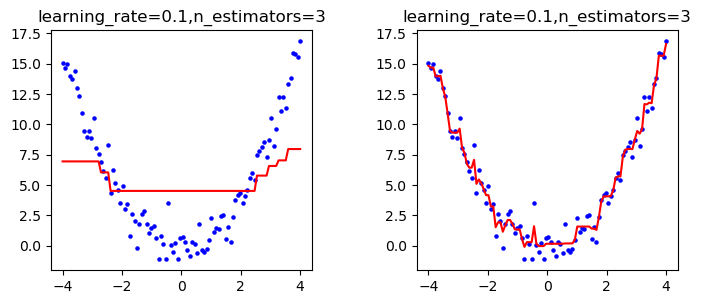

In [78]:
#等效的做法
from sklearn.ensemble import GradientBoostingRegressor
X=np.linspace(-4,4,100)
Y=X**2+np.random.normal(0,1,100)
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
gbrt1=GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=0.1)
gbrt2=GradientBoostingRegressor(max_depth=2,n_estimators=100,learning_rate=0.1)
gbrt1.fit(X,Y)
gbrt2.fit(X,Y)

#可视化结果
fig,axs=plt.subplots(1,2)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.25, top=0.75, wspace=0.4,hspace=0.6)
axs[0].scatter(X,Y,c='#0000FF',s=5)
axs[0].plot(X,gbrt1.predict(X),c="r")
axs[0].set_title("learning_rate=0.1,n_estimators=3")

axs[1].scatter(X,Y,c='#0000FF',s=5)
axs[1].plot(X,gbrt2.predict(X),c="r")
axs[1].set_title("learning_rate=0.1,n_estimators=3")

plt.show()



c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


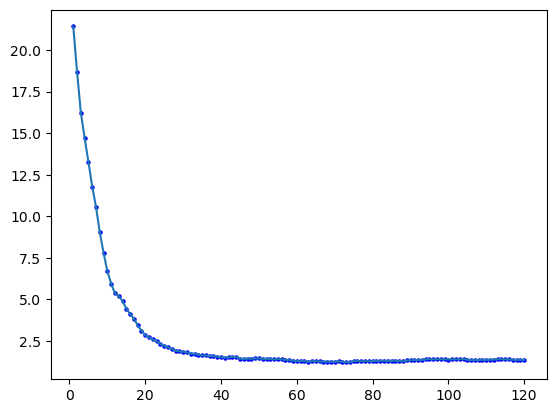

In [88]:
#如何获取最佳的树值
X_train,X_val,y_train,y_val=train_test_split(X,Y)
gbrt=GradientBoostingRegressor(max_depth=2,n_estimators=120,subsample=0.25)
gbrt.fit(X_train,y_train)
errors=[mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors)

gbrt_best=GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

#可视化
tree=[i for i in range(1,121)]
plt.scatter(tree,errors,c='#0000FF',s=5)
plt.plot(tree,errors)

In [87]:
gbrt=GradientBoostingRegressor(max_depth=2,warm_start=True)
min_val_error=float("inf")
error_going_up=0
for n_estimators in range(1,120):
    gbrt.n_estimators=n_estimators
    gbrt.fit(X_train,y_train)
    y_pred=gbrt.predict(X_val)
    val_error=mean_squared_error(y_val,y_pred)
    if val_error<min_val_error:
        min_val_error=val_error
        error_going_up=0
    else:
        error_going_up+=1
        if error_going_up==5:
            break

c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A colum